In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from ray import tune
from ray import train
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\TonVo\anaconda3\envs\myenv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
torch.manual_seed(2023)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data = pd.read_excel('dataset_final.xlsx')
data = data.dropna(thresh=len(data.columns)-10)
data = data.fillna(method='ffill')
data.tail()

C:\Users\TonVo\AppData\Local\Temp\ipykernel_34188\2340567172.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


,DATE,NASDAQ100,NASDAQCOM,WILL5000PR,DAAA,DCOILWTICO,DGS30,DPRIME,T10Y2Y,T10Y3M,...,VOLUME,RETURN,ADL,WR,RVI,EMA,TR,UO,AAPL,MSFT
9788,2023-09-19,15191.23,13678.19,44733.86,5.10,91.16,4.43,8.5,-0.71,-1.17,...,3.614880e+09,-0.002151,2.153461e+12,-78.0646,0.6052,4463.8448,36.9199,4.2918,179.070007,328.649994
9789,2023-09-20,14969.92,13469.13,44327.34,5.07,89.20,4.40,8.5,-0.77,-1.21,...,3.308450e+09,-0.009395,2.150244e+12,-99.4135,0.3447,4455.6255,59.6499,2.5001,175.490005,320.769989
9790,2023-09-21,14694.24,13223.98,43579.31,5.21,89.56,4.56,8.5,-0.63,-1.08,...,3.662340e+09,-0.016401,2.146712e+12,-99.6086,0.2868,4438.8754,73.0303,0.6814,173.929993,319.529999
9791,2023-09-22,14701.10,13211.81,43482.13,5.15,90.00,4.53,8.5,-0.66,-1.12,...,3.349570e+09,-0.002296,2.143947e+12,-98.1952,0.2777,4423.0334,40.9097,0.1672,174.789993,317.010010
9792,2023-09-25,14768.90,13271.32,43654.44,5.29,89.68,4.67,8.5,-0.54,-1.03,...,3.195650e+09,0.004023,2.146952e+12,-83.4011,0.4286,4411.6209,35.8096,0.0924,176.080002,317.540009


In [4]:
len(data)

9460

In [5]:
def split_data(data, lookback):
    data_raw = data.to_numpy()
    X_list = []
    y_list = []

    for index in range(len(data_raw) - lookback): 
        X_list.append(data_raw[index: index + lookback, 1:])
        y_list.append(data_raw[index + lookback, -9])

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y

lookback = 14

X, y = split_data(data, lookback)

In [7]:
train_length = int(len(X) * 0.85)
val_length = int(len(X) * 0.05)
test_length = len(X) - train_length - val_length

In [9]:
X_train = X[:train_length]
y_train = y[:train_length]

X_val = X[train_length:train_length+val_length]
y_val = y[train_length:train_length+val_length]

X_test = X[train_length+val_length:]
y_test = y[train_length+val_length:]

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_2D = X_train.reshape(-1, X_train.shape[-1])

X_train_scaled_2D = scaler.fit_transform(X_train_2D)

X_train_scaled = X_train_scaled_2D.reshape(X_train.shape)

X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [12]:
X_train_t = torch.tensor(X_train_scaled).float()
y_train_t = torch.tensor(y_train).float()

X_val_t = torch.tensor(X_val_scaled).float()
y_val_t = torch.tensor(y_val).float()

X_test_t = torch.tensor(X_test_scaled).float()
y_test_t = torch.tensor(y_test).float()

In [13]:
config = {
    "lr": tune.loguniform(1e-5, 1e-3),
    "batch_size": tune.choice([16, 32, 64, 128]),
    "hidden_dims": tune.grid_search([[256, 128], [512, 128], [512, 256, 128], [256, 512, 256, 128], [128, 256, 512, 128]]),
    "num_epochs": tune.choice([30, 50, 75, 100, 150])
}

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(LSTMModel, self).__init__()
        
        self.lstm_layers = nn.ModuleList()
        
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dims[0], batch_first=True))
        
        for i in range(1, len(hidden_dims)):
            self.lstm_layers.append(nn.LSTM(hidden_dims[i-1], hidden_dims[i], batch_first=True))
        
        self.fc1 = nn.Linear(hidden_dims[-1], 64)
        self.leakyrelu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        
        x = x[:, -1, :]
        
        x = self.fc1(x)
        x = self.leakyrelu1(x)
        x = self.fc2(x)
        
        return x

In [15]:
def madl_loss(y_true, y_pred):
    N = y_true.size(0)
    sign = torch.sign(y_true * y_pred)
    loss = (1 - sign) * torch.abs(y_true - y_pred)
    return torch.sum(loss) / N

In [16]:
input_dim = 22
output_dim = 1

In [17]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(X_train_t, y_train_t)
val_data = TensorDataset(X_val_t, y_val_t)

In [18]:
def train_model(config):
    model = LSTMModel(input_dim, [int(dim) for dim in config["hidden_dims"]], output_dim)
    model = model.to(device)

    train_dataloader = DataLoader(train_data, batch_size=int(config["batch_size"]), shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=int(config["batch_size"]), shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"])

    best_loss = float('inf')
    best_model = None

    for epoch in range(int(config["num_epochs"])):
        model.train()  
        train_loss = 0.0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = madl_loss(targets, outputs)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss /= len(train_dataloader)

        model.eval() 
        with torch.no_grad():
            val_loss = 0.0
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = madl_loss(targets, outputs)
                val_loss += loss.item()

            val_loss /= len(val_dataloader)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            
            folder = r'' # replace with your folder path
            model_path = f'{folder}/LSTM_{config["hidden_dims"]}_val_loss_{val_loss:.2f}.pth'
            torch.save(best_model, model_path)


        print(f'Epoch {epoch+1}/{config["num_epochs"]}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        train.report({'loss': val_loss})

    model.load_state_dict(best_model)

In [56]:
analysis = tune.run(
    train_model,
    config=config,
    resources_per_trial={"CPU": 16, "GPU": 1},
    num_samples=100
)

2023-12-01 09:28:06,169	INFO tune.py:586 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2023-12-01 09:28:11,995	WARNING worker.py:2074 -- Warning: The actor ImplicitFunc is very large (20 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Trial name,loss
train_model_8d3f9_00000,0.22573
train_model_8d3f9_00001,0.220159
train_model_8d3f9_00002,0.421247
train_model_8d3f9_00003,0.097644
train_model_8d3f9_00004,0.204564
train_model_8d3f9_00005,0.109354
train_model_8d3f9_00006,0.222354
train_model_8d3f9_00007,0.206298
train_model_8d3f9_00008,0.111104
train_model_8d3f9_00009,0.767272


(train_model pid=30336) Epoch 1/100, Train Loss: 0.3767, Validation Loss: 0.2333
(train_model pid=30336) Epoch 2/100, Train Loss: 0.2535, Validation Loss: 0.2373
(train_model pid=30336) Epoch 3/100, Train Loss: 0.2498, Validation Loss: 0.2457
(train_model pid=30336) Epoch 4/100, Train Loss: 0.2520, Validation Loss: 0.2614
(train_model pid=30336) Epoch 5/100, Train Loss: 0.2518, Validation Loss: 0.2257
(train_model pid=30336) Epoch 6/100, Train Loss: 0.2481, Validation Loss: 0.2267
(train_model pid=30336) Epoch 7/100, Train Loss: 0.2464, Validation Loss: 0.2145
(train_model pid=30336) Epoch 8/100, Train Loss: 0.2483, Validation Loss: 0.2404
(train_model pid=30336) Epoch 9/100, Train Loss: 0.2473, Validation Loss: 0.2215
(train_model pid=30336) Epoch 10/100, Train Loss: 0.2437, Validation Loss: 0.2219
(train_model pid=30336) Epoch 11/100, Train Loss: 0.2456, Validation Loss: 0.2148
(train_model pid=30336) Epoch 12/100, Train Loss: 0.2495, Validation Loss: 0.2292
(train_model pid=30336) E

2023-12-01 11:15:27,673	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-12-01 11:15:30,490	INFO tune.py:1047 -- Total run time: 6444.32 seconds (6441.21 seconds for the tuning loop).
2023-12-01 11:15:30,491	WARNING tune.py:1062 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)


(train_model pid=30336) Epoch 39/50, Train Loss: 0.1226, Validation Loss: 0.1010


2023-12-01 11:15:30,777	WARNING experiment_analysis.py:185 -- Failed to fetch metrics for 17 trial(s):
- train_model_8d3f9_00035: FileNotFoundError('Could not fetch metrics for train_model_8d3f9_00035: both result.json and progress.csv were not found at C:/Users/TonVo/ray_results/train_model_2023-12-01_09-28-06/train_model_8d3f9_00035_35_batch_size=128,hidden_dims=256_128,lr=0.0000,num_epochs=30_2023-12-01_10-28-54')
- train_model_8d3f9_00036: FileNotFoundError('Could not fetch metrics for train_model_8d3f9_00036: both result.json and progress.csv were not found at C:/Users/TonVo/ray_results/train_model_2023-12-01_09-28-06/train_model_8d3f9_00036_36_batch_size=128,hidden_dims=512_128,lr=0.0002,num_epochs=150_2023-12-01_10-31-41')
- train_model_8d3f9_00037: FileNotFoundError('Could not fetch metrics for train_model_8d3f9_00037: both result.json and progress.csv were not found at C:/Users/TonVo/ray_results/train_model_2023-12-01_09-28-06/train_model_8d3f9_00037_37_batch_size=16,hidden_di

In [19]:
model = LSTMModel(22, [256, 512, 256, 128], 1).to(device)

model.load_state_dict(torch.load(r'')) # replace with your model path

<All keys matched successfully>

In [21]:
class LSTMLayer1(nn.Module):
    def __init__(self):
        super(LSTMLayer1, self).__init__()
        self.lstm = nn.LSTM(22, 256, batch_first=True)
        
    def forward(self, x):
        output, _ = self.lstm(x)
        return output

class LSTMLayer2(nn.Module):
    def __init__(self):
        super(LSTMLayer2, self).__init__()
        self.lstm = nn.LSTM(256, 512, batch_first=True)
        
    def forward(self, x):
        output, _ = self.lstm(x)
        return output

class LSTMLayer3(nn.Module):
    def __init__(self):
        super(LSTMLayer3, self).__init__()
        self.lstm = nn.LSTM(512, 256, batch_first=True)
        
    def forward(self, x):
        output, _ = self.lstm(x)
        return output

class LSTMLayer4(nn.Module):
    def __init__(self):
        super(LSTMLayer4, self).__init__()
        self.lstm = nn.LSTM(256, 128, batch_first=True)
        
    def forward(self, x):
        output, _ = self.lstm(x)
        return output

class LSTMWrapper(nn.Module):
    def __init__(self, lstm1, lstm2, lstm3, lstm4):
        super(LSTMWrapper, self).__init__()
        self.lstm1 = lstm1
        self.lstm2 = lstm2
        self.lstm3 = lstm3
        self.lstm4 = lstm4
        self.fc1 = nn.Linear(128, 64)
        self.leakyrelu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.lstm3(x)
        x = self.lstm4(x)
        x = self.fc1(x[:, -1, :])
        x = self.leakyrelu1(x)
        x = self.fc2(x)
        return x

In [22]:
from collections import OrderedDict

old_state_dict = torch.load(r'') # replace with your model path

new_state_dict = OrderedDict()

for k, v in old_state_dict.items():
    if 'lstm_layers.0' in k:
        new_key = k.replace('lstm_layers.0', 'lstm')
        new_state_dict[new_key] = v

lstm_layer1 = LSTMLayer1()

lstm_layer1.load_state_dict(new_state_dict, strict=False)

for k, v in old_state_dict.items():
    if 'lstm_layers.1' in k:
        new_key = k.replace('lstm_layers.1', 'lstm')
        new_state_dict[new_key] = v

lstm_layer2 = LSTMLayer2()

lstm_layer2.load_state_dict(new_state_dict, strict=False)

for k, v in old_state_dict.items():
    if 'lstm_layers.2' in k:
        new_key = k.replace('lstm_layers.2', 'lstm')
        new_state_dict[new_key] = v

lstm_layer3 = LSTMLayer3()

lstm_layer3.load_state_dict(new_state_dict, strict=False)

for k, v in old_state_dict.items():
    if 'lstm_layers.3' in k:
        new_key = k.replace('lstm_layers.3', 'lstm')
        new_state_dict[new_key] = v

lstm_layer4 = LSTMLayer4()

lstm_layer4.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [23]:
new_state_dict = OrderedDict()

for k, v in old_state_dict.items():
    if 'fc1' in k or 'fc2' in k or 'leakyrelu1' in k:
        new_state_dict[k] = v

lstm_wrapper = LSTMWrapper(lstm_layer1, lstm_layer2, lstm_layer3, lstm_layer4)

lstm_wrapper.load_state_dict(new_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['lstm1.lstm.weight_ih_l0', 'lstm1.lstm.weight_hh_l0', 'lstm1.lstm.bias_ih_l0', 'lstm1.lstm.bias_hh_l0', 'lstm2.lstm.weight_ih_l0', 'lstm2.lstm.weight_hh_l0', 'lstm2.lstm.bias_ih_l0', 'lstm2.lstm.bias_hh_l0', 'lstm3.lstm.weight_ih_l0', 'lstm3.lstm.weight_hh_l0', 'lstm3.lstm.bias_ih_l0', 'lstm3.lstm.bias_hh_l0', 'lstm4.lstm.weight_ih_l0', 'lstm4.lstm.weight_hh_l0', 'lstm4.lstm.bias_ih_l0', 'lstm4.lstm.bias_hh_l0'], unexpected_keys=[])

In [24]:
from captum.attr import LayerConductance

lstm_wrapper = lstm_wrapper.to(device)

lc_layer1 = LayerConductance(lstm_wrapper, lstm_wrapper.lstm1)

X_test_t_limited = X_test_t[:150].to(device)

median_baseline = X_test_t_limited.median(dim=0).values

median_baseline = median_baseline.unsqueeze(0).expand_as(X_test_t_limited)

conductance_values_layer1 = lc_layer1.attribute(X_test_t_limited, baselines=median_baseline)

average_conductance_layer1 = torch.mean(conductance_values_layer1, dim=0)

In [25]:
lc_layer2 = LayerConductance(lstm_wrapper, lstm_wrapper.lstm2)

conductance_values_layer2 = lc_layer2.attribute(X_test_t_limited, baselines=median_baseline)

average_conductance_layer2 = torch.mean(conductance_values_layer2, dim=0)

In [27]:
lc_layer3 = LayerConductance(lstm_wrapper, lstm_wrapper.lstm3)

conductance_values_layer3 = lc_layer3.attribute(X_test_t_limited, baselines=median_baseline)

average_conductance_layer3 = torch.mean(conductance_values_layer3, dim=0)

In [29]:
lc_layer4 = LayerConductance(lstm_wrapper, lstm_wrapper.lstm4)

conductance_values_layer4 = lc_layer4.attribute(X_test_t_limited, baselines=median_baseline)

average_conductance_layer4 = torch.mean(conductance_values_layer4, dim=0)

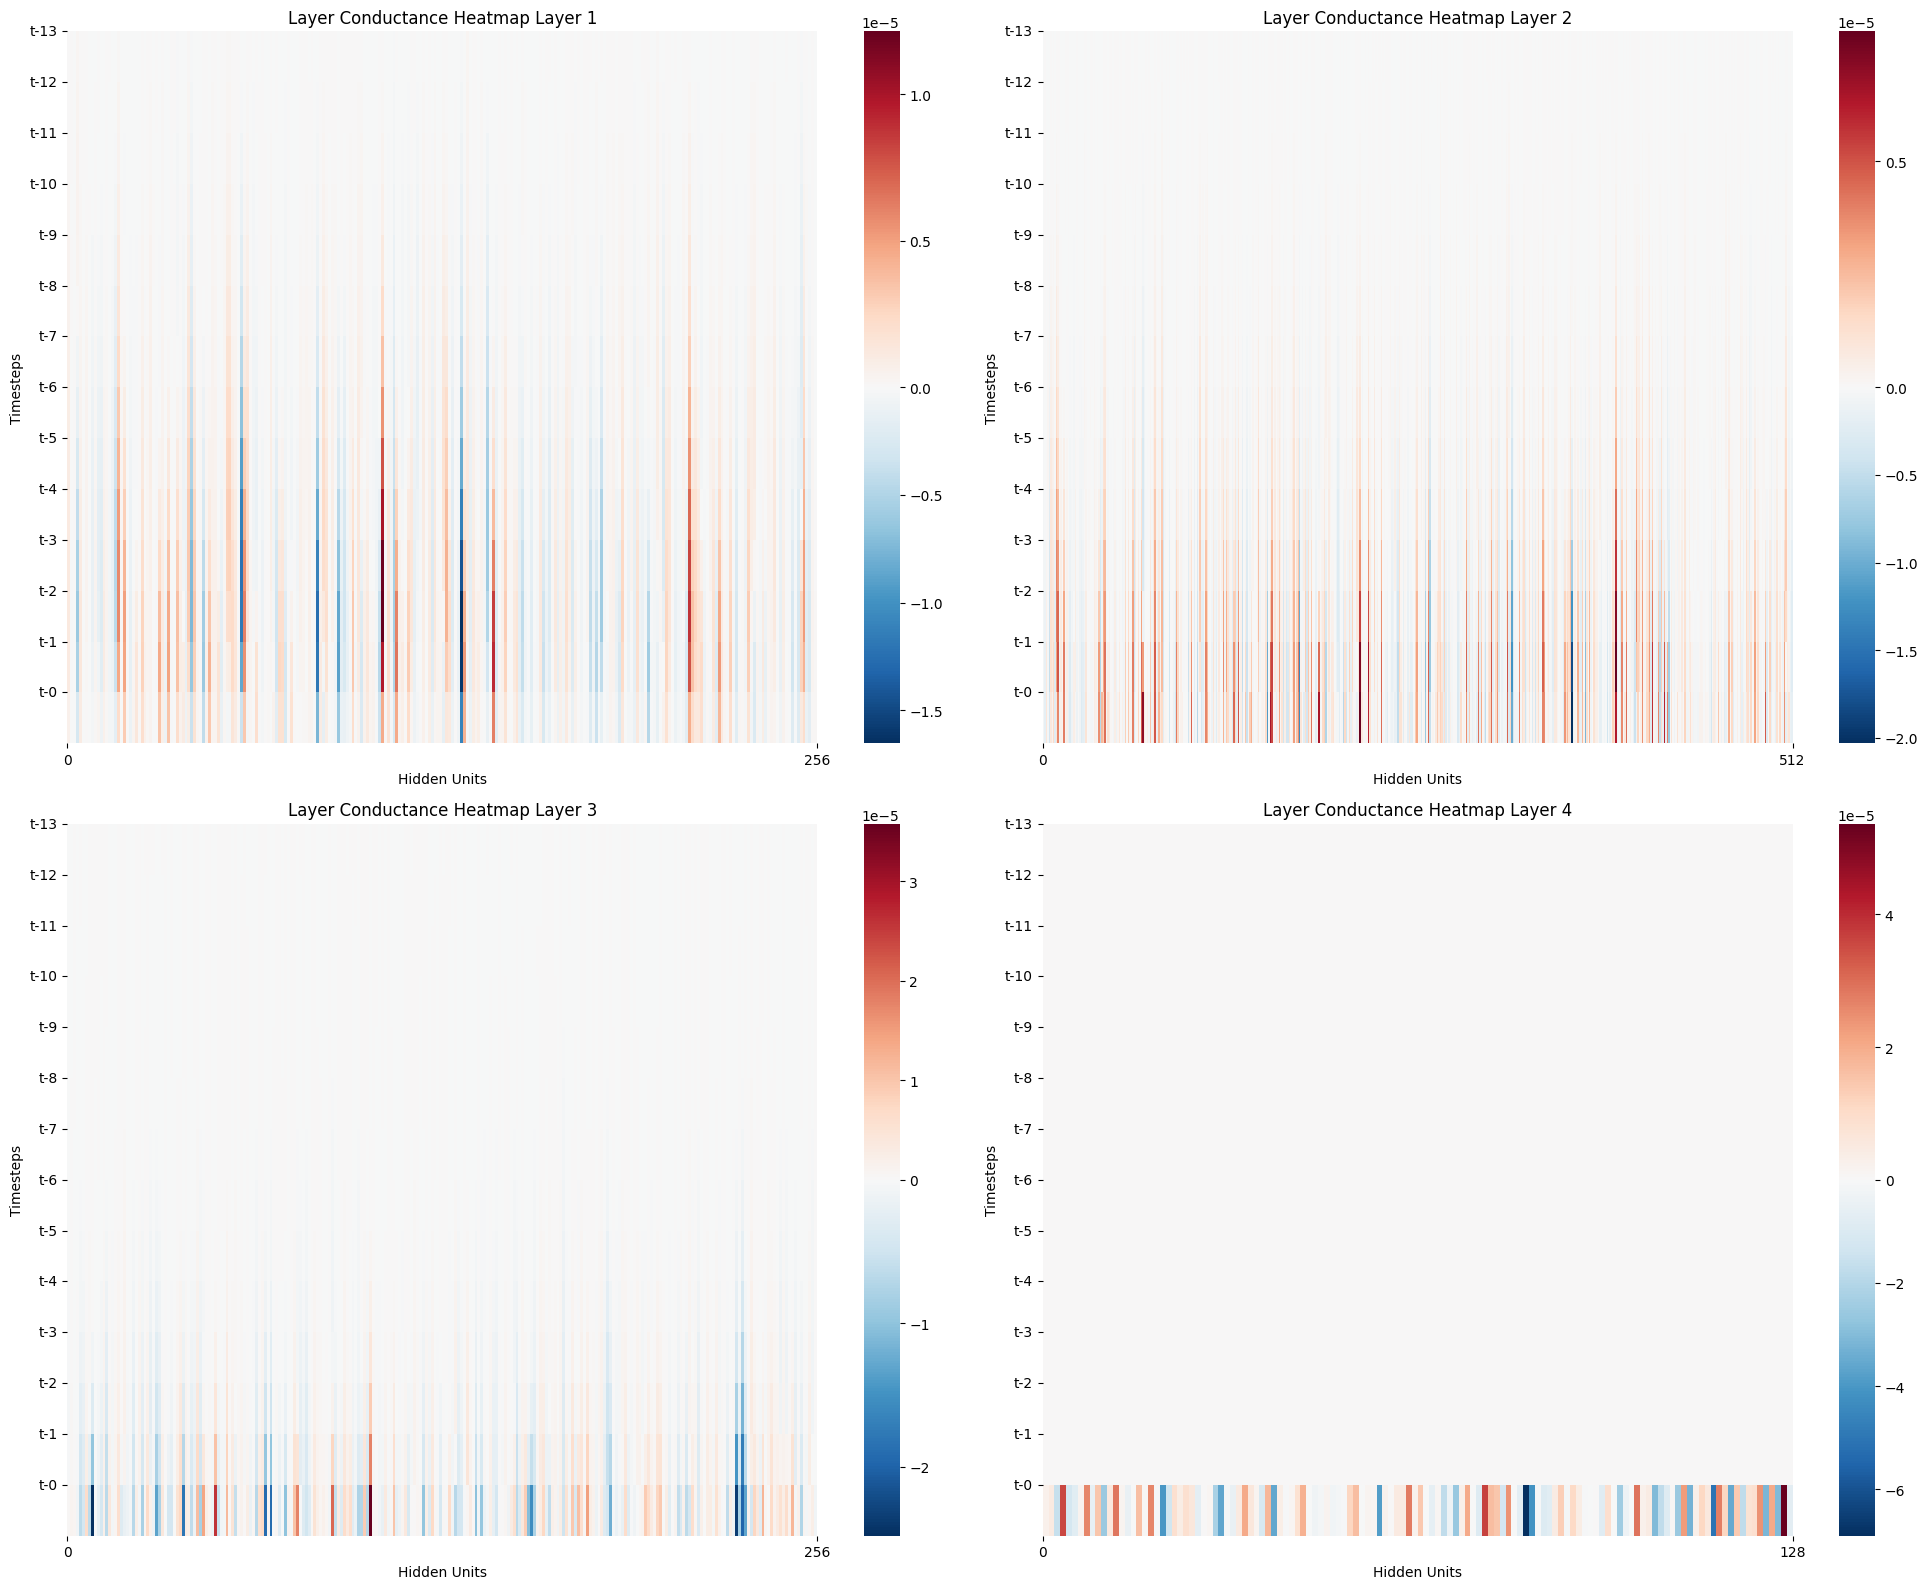

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

# Move the tensors to CPU and convert them to numpy arrays
average_conductance_layer1_cpu = average_conductance_layer1.cpu().detach().numpy()
average_conductance_layer2_cpu = average_conductance_layer2.cpu().detach().numpy()
average_conductance_layer3_cpu = average_conductance_layer3.cpu().detach().numpy()
average_conductance_layer4_cpu = average_conductance_layer4.cpu().detach().numpy()

fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Create the heatmaps with individual scales
for i, (ax, data) in enumerate(zip(axs.flat, [average_conductance_layer1_cpu, average_conductance_layer2_cpu, average_conductance_layer3_cpu, average_conductance_layer4_cpu])):
    vmin = max(data.min(), -1)  # adjust here
    vmax = min(data.max(), 1)  # adjust here
    divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    sns.heatmap(data, cmap='RdBu_r', ax=ax, norm=divnorm)  # change colormap here
    ax.set_title(f'Layer Conductance Heatmap Layer {i+1}')
    ax.set(xlabel='Hidden Units', ylabel='Timesteps')
    ax.set_yticks(range(14))
    ax.set_yticklabels(['t-'+str(i) for i in range(13, -1, -1)], rotation=0)

axs[0, 0].set_xticks([0, 256])
axs[0, 0].set_xticklabels([0, 256], rotation=0)
axs[0, 1].set_xticks([0, 512])
axs[0, 1].set_xticklabels([0, 512], rotation=0)
axs[1, 0].set_xticks([0, 256])
axs[1, 0].set_xticklabels([0, 256], rotation=0)
axs[1, 1].set_xticks([0, 128])
axs[1, 1].set_xticklabels([0, 128], rotation=0)

plt.tight_layout()
# save a svg of the output
plt.savefig('layer_conductance_heatmaps.svg', format='svg', dpi=300)
plt.show()

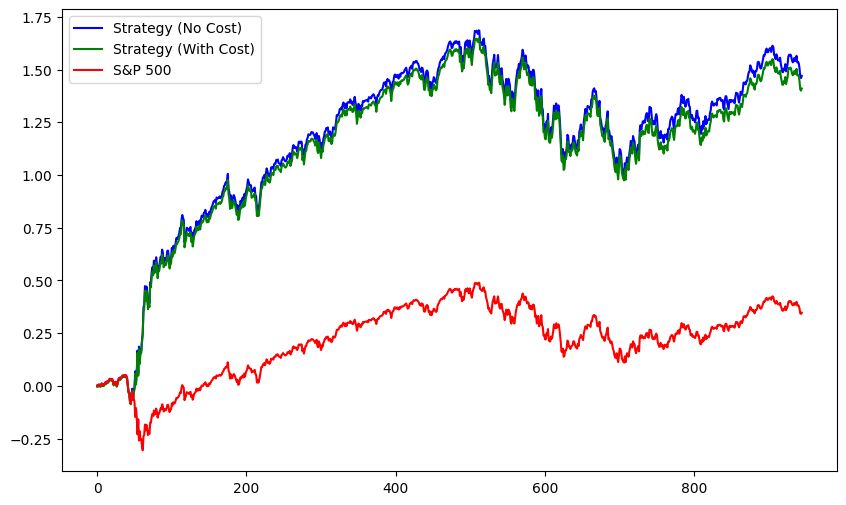

In [20]:
outputs_test = model(X_test_t.to(device))

outputs1_np = outputs_test.detach().cpu().numpy()
y_test1_t_np = y_test_t.detach().cpu().numpy()

df = pd.DataFrame({
    'PredictedReturn': outputs1_np.flatten(),
    'AssetReturn': y_test1_t_np.flatten()
})

df['Signal'] = np.sign(df['PredictedReturn'])

trading_cost = 0.005

df['StrategyReturnNoCost'] = df['Signal'] * df['AssetReturn']

df['StrategyReturnWithCost'] = df['StrategyReturnNoCost'] - trading_cost * (df['Signal'].diff() != 0)

df['CumulativeReturnNoCost'] = (1 + df['StrategyReturnNoCost']).cumprod() - 1

df['CumulativeReturnWithCost'] = (1 + df['StrategyReturnWithCost']).cumprod() - 1

df['BenchmarkCumulativeReturn'] = (1 + df['AssetReturn']).cumprod() - 1

plt.figure(figsize=(10,6))
plt.plot(df['CumulativeReturnNoCost'], label='Strategy (No Cost)', color='blue')
plt.plot(df['CumulativeReturnWithCost'], label='Strategy (With Cost)', color='green')
plt.plot(df['BenchmarkCumulativeReturn'], label='S&P 500', color='red')
plt.legend()
plt.show()

In [20]:
outputs_test = model(X_test_t.to(device))

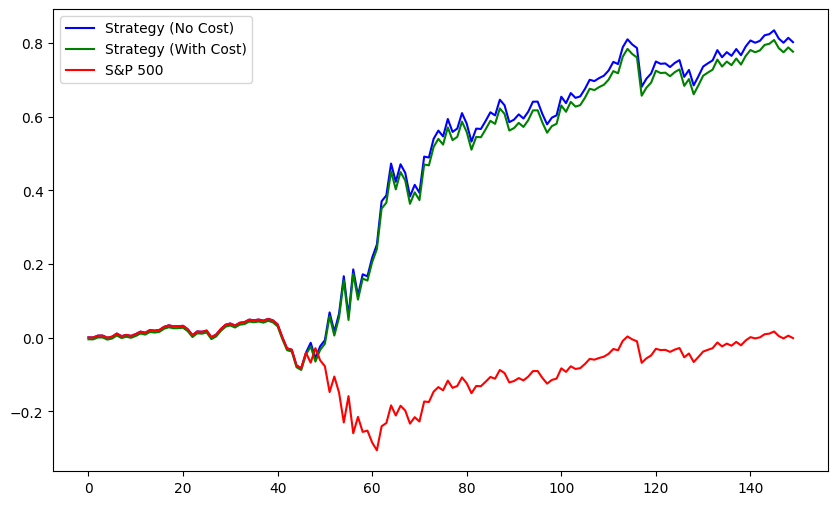

In [22]:
df = pd.DataFrame({
    'PredictedReturn': outputs1_np.flatten(),
    'AssetReturn': y_test1_t_np.flatten()
})

df['Signal'] = np.sign(df['PredictedReturn'])

trading_cost = 0.005

df['StrategyReturnNoCost'] = df['Signal'] * df['AssetReturn']

df['StrategyReturnWithCost'] = df['StrategyReturnNoCost'] - trading_cost * (df['Signal'].diff() != 0)

df['CumulativeReturnNoCost'] = (1 + df['StrategyReturnNoCost']).cumprod() - 1

df['CumulativeReturnWithCost'] = (1 + df['StrategyReturnWithCost']).cumprod() - 1

df['BenchmarkCumulativeReturn'] = (1 + df['AssetReturn']).cumprod() - 1

df = df.iloc[:150]

plt.figure(figsize=(10,6))
plt.plot(df['CumulativeReturnNoCost'], label='Strategy (No Cost)', color='blue')
plt.plot(df['CumulativeReturnWithCost'], label='Strategy (With Cost)', color='green')
plt.plot(df['BenchmarkCumulativeReturn'], label='S&P 500', color='red')
plt.legend()
plt.show()

In [45]:
factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3)

factors.rename(columns={'Unnamed: 0':'date'}, inplace=True)

factors.tail()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
15161,20230925,0.39,-0.07,0.35,0.59,-0.46,0.021
15162,20230926,-1.46,0.35,-0.50,-0.36,-0.08,0.021
15163,20230927,0.13,0.78,0.12,0.18,-0.27,0.021
15164,20230928,0.65,0.19,0.03,0.43,-0.03,0.021
15165,20230929,-0.27,-0.02,0.30,-0.18,-0.15,0.021


In [46]:
data['DATE'] = pd.to_datetime(data['DATE'])

factors['date'] = pd.to_datetime(factors['date'], format='%Y%m%d')

data = data.tail(945)

factors = factors[factors['date'].isin(data['DATE'])]

In [47]:
factors.iloc[:, 1:] = factors.iloc[:, 1:] / 100

In [48]:
df_regression = pd.DataFrame()

df_regression['ExcessReturn'] = df['StrategyReturnWithCost'] - factors['RF'].values

In [49]:
import statsmodels.api as sm

factors = factors.reset_index(drop=True)

y = df_regression['ExcessReturn']
X = factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ExcessReturn   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     63.31
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           5.69e-57
Time:                        20:27:06   Log-Likelihood:                 2782.0
No. Observations:                 945   AIC:                            -5552.
Df Residuals:                     939   BIC:                            -5523.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.804      0.072   -6.61e-05       0.002
Mkt-RF         0.4342      0.030     14.522      0.000       0.376       0.493
SMB            0.1882      0.062      3.036      0.002       0.067       0.310
HML           -0.2484      0.053     -4.704      0.000      -0.352      -0.145
RMW            0.1667      0.076      2.197      0.028       0.018       0.316
CMA           -0.0302      0.098     -0.309      0.758      -0.223       0.162
==============================================================================
Omnibus:                      848.321   Durbin-Watson:                   2.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           168271.150
Skew:                           3.364   Prob(JB):                         0.00
Kurtosis:                      68.025   Cond. No.                         255.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
y = df_regression['ExcessReturn']

X = factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

y = y.iloc[:150]
X = X.iloc[:150]

X = sm.add_constant(X)

model_150 = sm.OLS(y, X).fit()

print(model_150.summary())

                            OLS Regression Results                            
Dep. Variable:           ExcessReturn   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.155
Date:                Wed, 06 Dec 2023   Prob (F-statistic):              0.335
Time:                        20:43:39   Log-Likelihood:                 336.89
No. Observations:                 150   AIC:                            -661.8
Df Residuals:                     144   BIC:                            -643.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      1.925      0.0

In [22]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model.cuda())

X_test_t_subset = X_test_t[:200]

median_baseline = X_test_t_subset.median(dim=0).values

median_baseline = median_baseline.unsqueeze(0).expand_as(X_test_t_subset)

attributions, delta = ig.attribute(X_test_t_subset.to(device), median_baseline.to(device), target=0, return_convergence_delta=True)

In [23]:
average_attributions_median = attributions.mean(dim=0).cpu().numpy()

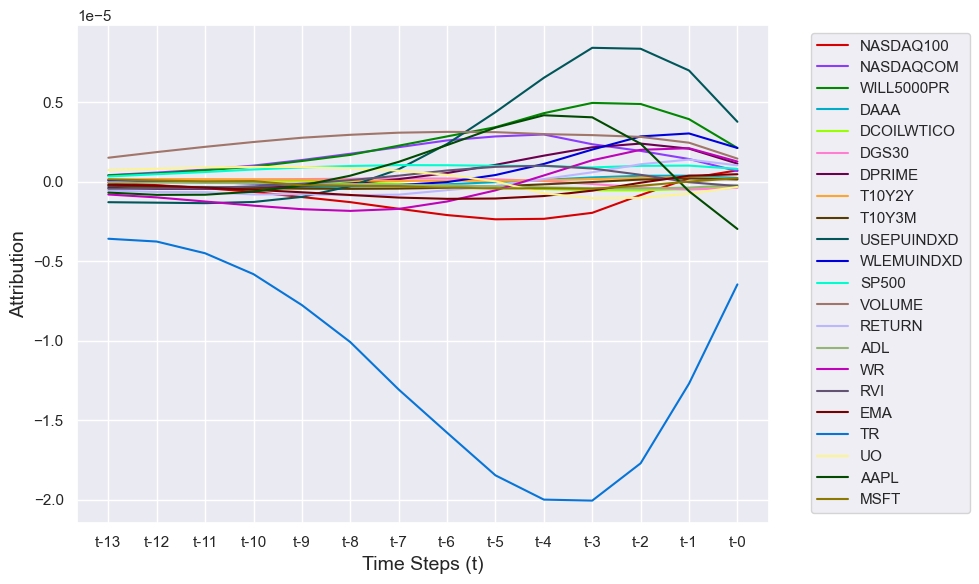

In [26]:
import colorcet as cc

fig, ax = plt.subplots(figsize=(10, 6))

sns.set()

feature_names = ['NASDAQ100', 'NASDAQCOM', 'WILL5000PR', 'DAAA', 'DCOILWTICO',
                 'DGS30', 'DPRIME', 'T10Y2Y', 'T10Y3M', 'USEPUINDXD', 'WLEMUINDXD',
                 'SP500', 'VOLUME', 'RETURN', 'ADL', 'WR', 'RVI', 'EMA', 'TR', 'UO',
                 'AAPL', 'MSFT']

# Get the colorcet palette
cmap = sns.color_palette(cc.glasbey, n_colors=len(feature_names))

for i in range(average_attributions_median.shape[1]):
    sns.lineplot(x=range(average_attributions_median.shape[0]), y=average_attributions_median[:, i], ax=ax, label=feature_names[i], color=cmap[i])

ax.set_xlabel('Time Steps (t)', fontsize=14)
ax.set_ylabel('Attribution', fontsize=14)

ax.set_xticks(range(average_attributions_median.shape[0]))
ax.set_xticklabels([f't-{average_attributions_median.shape[0] - i - 1}' for i in range(average_attributions_median.shape[0])])  # Reverse the labels

ax.grid(True)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.savefig('average_attributions_median.svg')
plt.show()

In [27]:
average_attributions_median_tensor = torch.from_numpy(average_attributions_median)

attributions_sum = torch.sum(torch.abs(average_attributions_median_tensor), dim=0)

attributions_normalized = attributions_sum / torch.sum(attributions_sum)

feature_names = ['NASDAQ100', 'NASDAQCOM', 'WILL5000PR', 'DAAA', 'DCOILWTICO',
                 'DGS30', 'DPRIME', 'T10Y2Y', 'T10Y3M', 'USEPUINDXD', 'WLEMUINDXD',
                 'SP500', 'VOLUME', 'RETURN', 'ADL', 'WR', 'RVI', 'EMA', 'TR', 'UO',
                 'AAPL', 'MSFT']

for i in range(average_attributions_median_tensor.shape[1]):
    print(f'Importance of {feature_names[i]}: {attributions_normalized[i]}')

Importance of NASDAQ100: 0.03447591604522026
Importance of NASDAQCOM: 0.05054830554017987
Importance of WILL5000PR: 0.07575759279083327
Importance of DAAA: 0.008164370456937872
Importance of DCOILWTICO: 0.00756093720787957
Importance of DGS30: 0.006444730503551637
Importance of DPRIME: 0.02916578483020773
Importance of T10Y2Y: 0.004454100932585222
Importance of T10Y3M: 0.008646221506336399
Importance of USEPUINDXD: 0.10572684755861643
Importance of WLEMUINDXD: 0.027479513052811797
Importance of SP500: 0.026353175571691843
Importance of VOLUME: 0.07892458003071429
Importance of RETURN: 0.022298726842127768
Importance of ADL: 0.006298873587019925
Importance of WR: 0.04107562696559976
Importance of RVI: 0.014023561496599321
Importance of EMA: 0.01804882588807992
Importance of TR: 0.35080725822817876
Importance of UO: 0.022408122249555306
Importance of AAPL: 0.05432893719222628
Importance of MSFT: 0.0070079915230468305


C:\Users\TonVo\AppData\Local\Temp\ipykernel_34188\583420797.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis_r', linewidth=0.3)


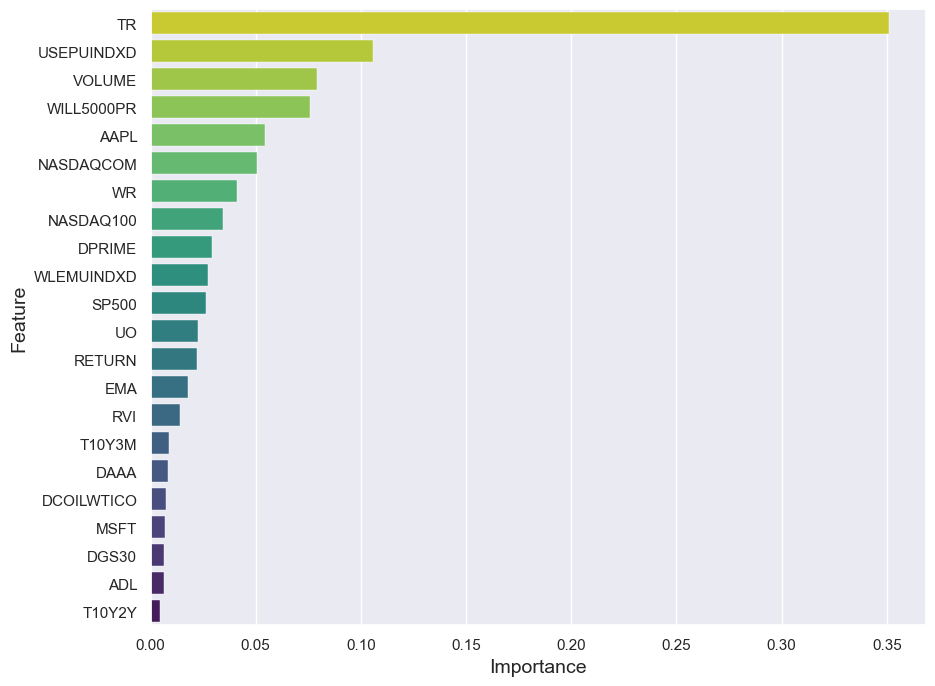

In [29]:
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': attributions_normalized
})

importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis_r', linewidth=0.3)

plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

plt.savefig('feature_importance.svg')

plt.show()

C:\Users\TonVo\AppData\Local\Temp\ipykernel_34188\4201814601.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f't-{average_attributions_tensor.shape[0] - i - 1}' for i in range(average_attributions_tensor.shape[0])], y=attributions_normalized_np, palette='viridis')


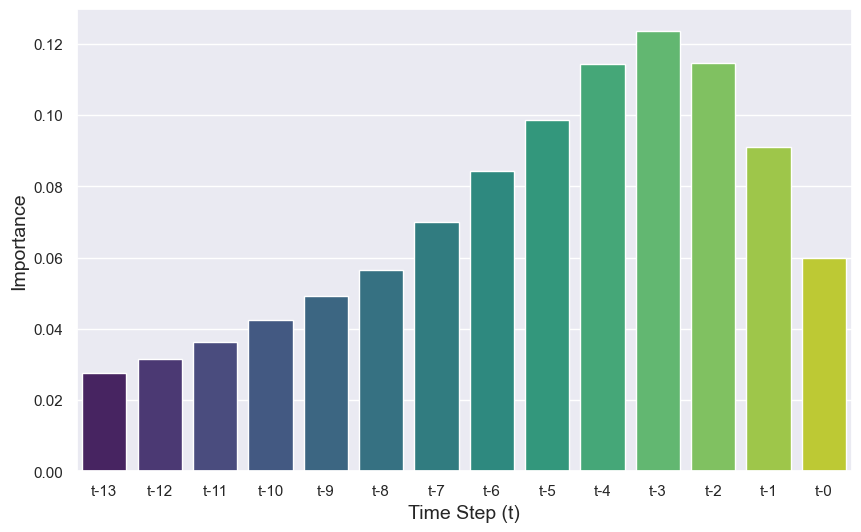

In [31]:
average_attributions_tensor = torch.from_numpy(average_attributions_median)

attributions_sum = torch.sum(torch.abs(average_attributions_tensor), dim=1)

attributions_normalized = attributions_sum / torch.sum(attributions_sum)

attributions_normalized_np = attributions_normalized.cpu().numpy()

plt.figure(figsize=(10, 6))
sns.barplot(x=[f't-{average_attributions_tensor.shape[0] - i - 1}' for i in range(average_attributions_tensor.shape[0])], y=attributions_normalized_np, palette='viridis')

plt.xlabel('Time Step (t)', fontsize=14)
plt.ylabel('Importance', fontsize=14)

plt.savefig('time_step_importance.svg')
plt.show()

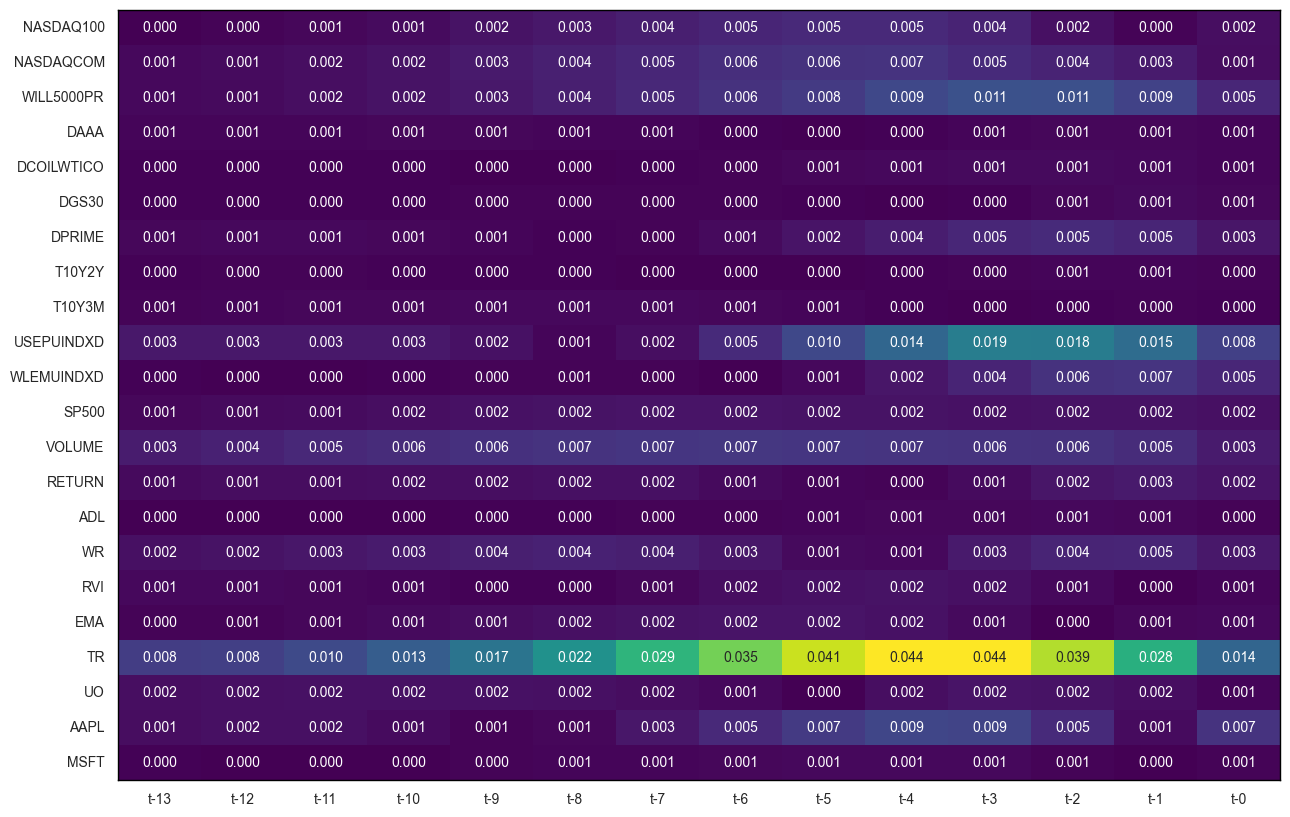

In [32]:
average_attributions_median_tensor = torch.from_numpy(average_attributions_median)

abs_attributions = torch.abs(average_attributions_median_tensor)

normalized_attributions = abs_attributions / torch.sum(abs_attributions)

normalized_attributions_np = normalized_attributions.cpu().numpy()

feature_names = ['NASDAQ100', 'NASDAQCOM', 'WILL5000PR', 'DAAA', 'DCOILWTICO',
                 'DGS30', 'DPRIME', 'T10Y2Y', 'T10Y3M', 'USEPUINDXD', 'WLEMUINDXD',
                 'SP500', 'VOLUME', 'RETURN', 'ADL', 'WR', 'RVI', 'EMA', 'TR', 'UO',
                 'AAPL', 'MSFT']

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(normalized_attributions_np.T, cmap='viridis', ax=ax, annot=True, fmt=".3f", annot_kws={"size": 10}, cbar=False)

ax.set_yticklabels(feature_names, fontsize=10, rotation=0)  
ax.set_xticklabels([f't-{average_attributions_median_tensor.shape[0] - i - 1}' for i in range(average_attributions_median_tensor.shape[0])], rotation=0, fontsize=10)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.savefig('heatmap.svg')
plt.show()